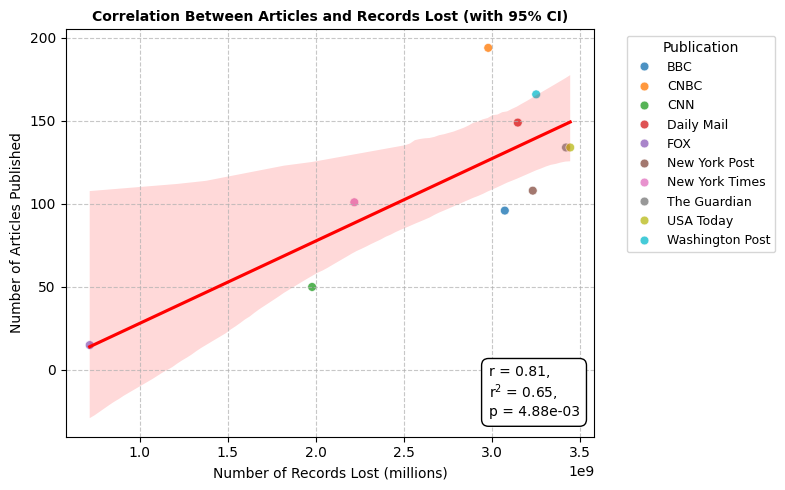

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
import scipy.stats as stats

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Deduplicate rows to ensure each breach is counted only once per publication
deduplicated_breach_summary = data.groupby(['Publication', 'ID'], as_index=False).agg({
    'records lost': 'first',  # Take the records lost for the unique breach
    'Headline': 'count',      # Count articles for this breach-publication pair
})

# Aggregate by publication to get the total records lost and article count
publication_summary = deduplicated_breach_summary.groupby('Publication', as_index=False).agg({
    'records lost': 'sum',  # Total records lost across unique breaches
    'Headline': 'sum'       # Total articles published across breaches
}).rename(columns={'Headline': 'article_count'})

# Plot correlation between TOTAL articles published vs. TOTAL records lost
plt.figure(figsize=(8, 5))

# Use scatterplot for color-encoding groupby column
scatter = sns.scatterplot(
    data=publication_summary,
    y='article_count',
    x='records lost',
    hue='Publication',  # Color encoding
    palette='tab10',
    alpha=0.8,
    s=40
)

# Add the regression line using regplot (no scatter points)
reg = sns.regplot(
    y='article_count',
    x='records lost',
    data=publication_summary,
    scatter=False,  # Don't plot scatter points since they're already plotted
    line_kws={'color': 'red'},
    ci=95
)

# Customize the plot
plt.title('Correlation Between Articles and Records Lost (with 95% CI)', fontsize=10, fontweight='bold')
plt.ylabel('Number of Articles Published', fontsize=10)
plt.xlabel('Number of Records Lost (millions)', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add custom legend for 'Publication'
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title='Publication', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9)

# Calculate correlation coefficient (Pearson's r)
correlation, _ = stats.pearsonr(publication_summary['records lost'], publication_summary['article_count'])

# Get regression line parameters (slope and intercept)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(publication_summary['records lost'], publication_summary['article_count'])

# Annotate the plot with correlation coefficient and regression parameters
plt.annotate(
    f'r = {correlation:.2f},\nr$^2$ = {rvalue**2:.2f},\np = {pvalue:.2e}', 
    xy=(0.8, 0.05), xycoords='axes fraction',
    fontsize=10, color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()

plt.close()

In [147]:
# import pandas as pd
# import seaborn as sns
# import numpy as np
# import missingno as msno
# from matplotlib import pyplot as plt
# import scipy.stats as stats

# # Load data
# data = pd.read_csv(
#     "../../data/article_company_breach/joined_articles_company_breaches_no_duplicates.csv",
#     encoding="ISO-8859-1",
#     low_memory=False,
# )

# # Prepare data for plotting
# individual_breaches = data.groupby('ID').agg({
#     'organisation': 'first',       # Company name
#     'year': 'first',               # Year of breach
#     'records lost': 'first',       # Records lost
#     'Headline': 'count'            # Count of articles (number of headlines)
# }).reset_index()

# # Rename columns for clarity
# individual_breaches.rename(columns={'Headline': 'Article Count'}, inplace=True)

# # Scatter plot with labels and adjusted x-axis scale
# plt.figure(figsize=(14, 8))
# scatter_plot = sns.regplot(
#     data=individual_breaches, 
#     x='records lost', 
#     y='Article Count', 
#     logx=True,  # Apply logarithmic scale to x-axis
#     scatter_kws={'alpha': 0.7}, 
#     line_kws={'color': 'red'},
#     ci=95
# )

# # Add text labels for each point
# for i, row in individual_breaches.iterrows():
#     plt.text(
#         x=row['records lost'], 
#         y=row['Article Count'], 
#         s=f"{row['organisation']} ({row['year']})\n{row['records lost']:,.0f}", 
#         fontsize=8, alpha=0.7
#     )



# plt.title('Scatter Plot with Regression Line: Records Lost vs. Article Count')
# plt.xlabel('Records Lost (log scale)')
# plt.ylabel('Number of Articles')
# plt.grid(True)
# plt.show()



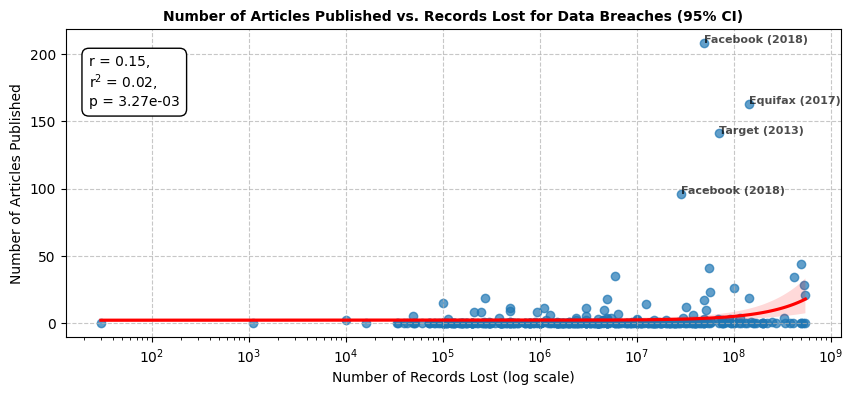

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Prepare data for plotting
individual_breaches = data.groupby('ID').agg({
    'organisation': 'first',       # Company name
    'year': 'first',               # Year of breach
    'records lost': 'first',       # Records lost
    'Headline': 'count',            # Count of articles (number of headlines)
    'sector': 'first'
}).reset_index()

# Rename columns for clarity
individual_breaches.rename(columns={'Headline': 'Article Count'}, inplace=True)

from scipy.stats import pearsonr, linregress

# Calculate correlation coefficient and regression parameters
correlation, _ = pearsonr(individual_breaches['records lost'], individual_breaches['Article Count'])
slope, intercept, rvalue, pvalue, stderr = linregress(
    individual_breaches['records lost'], 
    individual_breaches['Article Count']
)

# Plot scatter with regression line
plt.figure(figsize=(10, 4))
sns.regplot(
    data=individual_breaches, 
    x='records lost', 
    y='Article Count',
    scatter_kws={'alpha': 0.7}, 
    line_kws={'color': 'red'}
)

# color encode by sector
# sectors = individual_breaches['sector'].unique()
# palette = sns.color_palette('tab10', len(sectors))
# sector_colors = dict(zip(sectors, palette))

# plt.figure(figsize=(14, 8))
# scatter = sns.scatterplot(
#     data=individual_breaches, 
#     x='records lost', 
#     y='Article Count', 
#     hue='sector', 
#     palette=sector_colors,
#     alpha=0.7
# )
# sns.regplot(
#     data=individual_breaches, 
#     x='records lost', 
#     y='Article Count', 
#     scatter=False, 
#     line_kws={'color': 'red'}
# )

plt.xscale('log')

for i, row in individual_breaches.iterrows():
    if(row['Article Count'] > 45):
        plt.text(
            x=row['records lost'], 
            y=row['Article Count'], 
            s=f"{row['organisation']} ({row['year']})", 
            fontsize=8, alpha=0.7,
            fontweight='bold'
        )

plt.title('Number of Articles Published vs. Records Lost for Data Breaches (95% CI)', fontsize=10, fontweight='bold')
plt.xlabel('Number of Records Lost (log scale)', fontsize=10)
plt.ylabel('Number of Articles Published', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.annotate(
    f'r = {correlation:.2f},\nr$^2$ = {rvalue**2:.2f},\np = {pvalue:.2e}', 
    xy=(0.03, 0.75), xycoords='axes fraction',
    fontsize=10, color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.show()


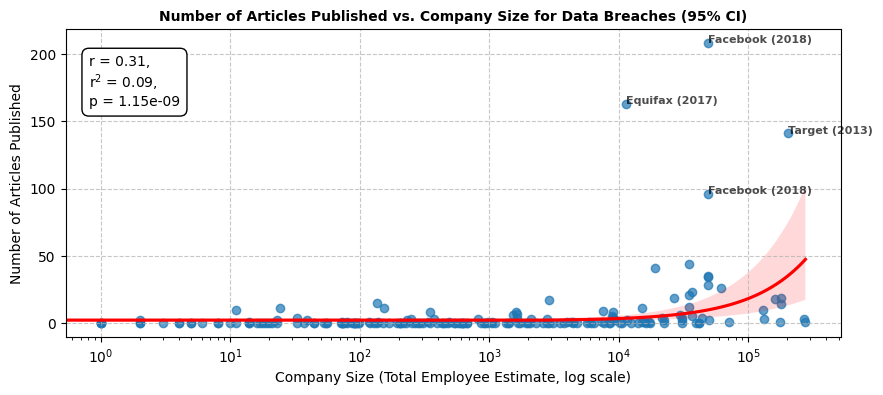

In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Prepare data for plotting
individual_breaches = data.groupby('ID').agg({
    'organisation': 'first',       # Company name
    'year': 'first',               # Year of breach
    # 'records lost': 'first',       # Records lost
    'Headline': 'count',            # Count of articles (number of headlines)
    'sector': 'first',
    'total employee estimate': 'first'
}).reset_index()

# Rename columns for clarity
individual_breaches.rename(columns={'Headline': 'Article Count'}, inplace=True)

from scipy.stats import pearsonr, linregress

# Calculate correlation coefficient and regression parameters
correlation, _ = pearsonr(individual_breaches['total employee estimate'], individual_breaches['Article Count'])
slope, intercept, rvalue, pvalue, stderr = linregress(
    individual_breaches['total employee estimate'], 
    individual_breaches['Article Count']
)

# Plot scatter with regression line
plt.figure(figsize=(10, 4))
sns.regplot(
    data=individual_breaches, 
    x='total employee estimate', 
    y='Article Count',
    scatter_kws={'alpha': 0.7}, 
    line_kws={'color': 'red'}
)

plt.xscale('log')

for i, row in individual_breaches.iterrows():
    if(row['Article Count'] > 45):
        plt.text(
            x=row['total employee estimate'], 
            y=row['Article Count'], 
            s=f"{row['organisation']} ({row['year']})", 
            fontsize=8, alpha=0.7,
            fontweight='bold'
        )

plt.title('Number of Articles Published vs. Company Size for Data Breaches (95% CI)', fontsize=10, fontweight='bold')
plt.xlabel('Company Size (Total Employee Estimate, log scale)', fontsize=10)
plt.ylabel('Number of Articles Published', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.annotate(
    f'r = {correlation:.2f},\nr$^2$ = {rvalue**2:.2f},\np = {pvalue:.2e}', 
    xy=(0.03, 0.75), xycoords='axes fraction',
    fontsize=10, color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.show()


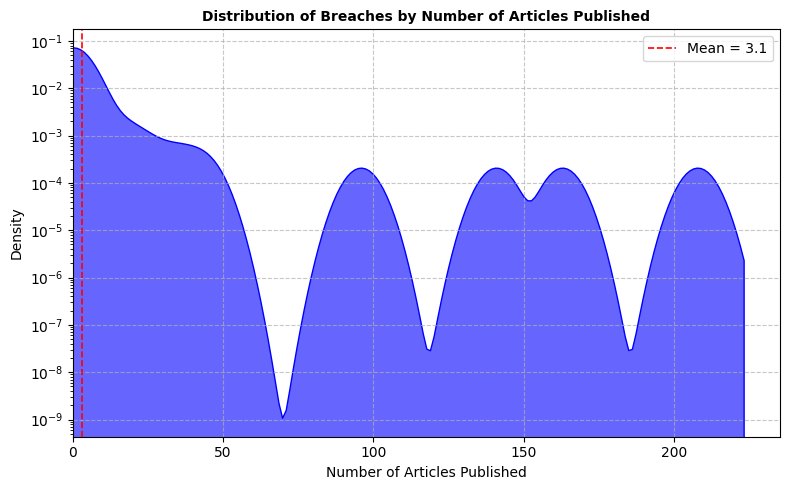

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Filter out rows with negative article counts
breach_summary = data.groupby('ID').agg({
    'records lost': 'sum',  # Total records lost
    'Headline': 'count',    # Count unique headlines (number of articles)
    'sector': 'first',      # Sector of the breach
    'data sensitivity': 'first',  # Sensitivity level
}).rename(columns={'Headline': 'article_count'})

breach_summary = breach_summary.reset_index()

# Remove breaches with negative article counts (if any)
breach_summary = breach_summary[breach_summary['article_count'] >= 0]

# Plot density of articles published for all breaches
plt.figure(figsize=(8, 5))

# Use kdeplot for density
sns.kdeplot(
    data=breach_summary,
    x='article_count',
    fill=True,
    color='blue',
    alpha=0.6,
)

# Add vertical line for the mean article count
mean_articles = breach_summary['article_count'].mean()
plt.axvline(mean_articles, color='red', linestyle='--', linewidth=1.2, label=f'Mean = {mean_articles:.1f}')

# Customize plot
plt.title('Distribution of Breaches by Number of Articles Published', fontsize=10, fontweight='bold')
plt.xlabel('Number of Articles Published', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# plt.yscale('log')

# Add x-axis limits to focus on valid range
plt.xlim(left=0)

# Add legend for mean line
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

plt.close()

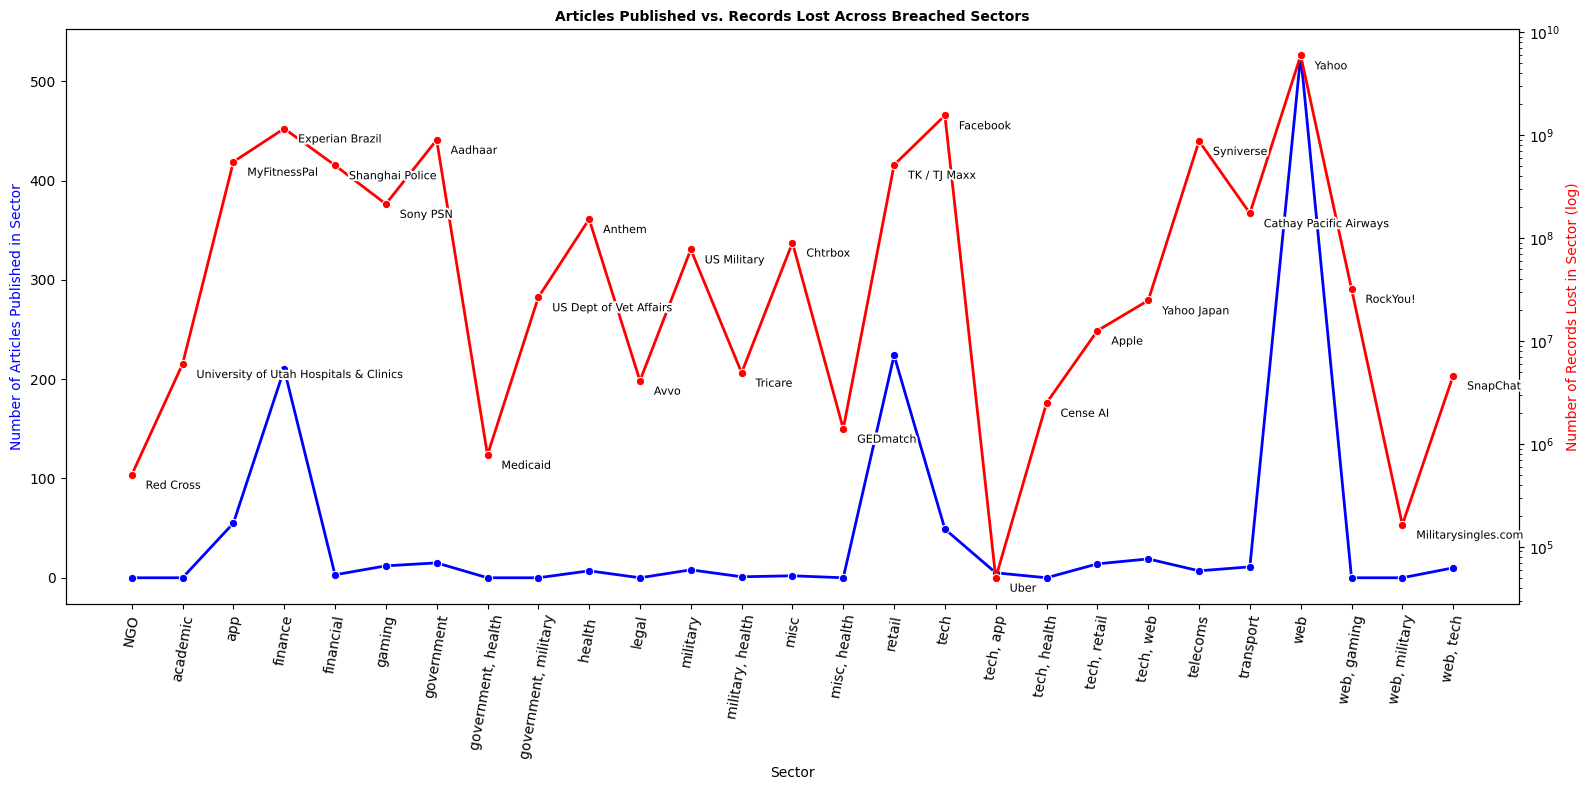

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patheffects import withStroke

# Load data
df = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Ensure 'records lost' is numeric
df['records lost'] = pd.to_numeric(df['records lost'], errors='coerce')

# Deduplicate breaches based on their unique breach ID
unique_breaches = df.drop_duplicates(subset='ID')

# Aggregate total articles by sector (counting headlines as before)
articles_by_sector = df.groupby('sector')['Headline'].count().reset_index()
articles_by_sector.columns = ['sector', 'total_articles']

# Aggregate total records lost by sector (summing only unique breaches)
records_by_sector = unique_breaches.groupby('sector')['records lost'].sum().reset_index()
records_by_sector.columns = ['sector', 'total_records_lost']

# Merge both dataframes on sector
aggregated_data = pd.merge(articles_by_sector, records_by_sector, on='sector', how='outer')

# Find the companies with the highest articles and records lost for each sector
highest_articles = (
    df.groupby(['sector', 'organisation'])['Headline']
    .count()
    .reset_index()
    .sort_values(by=['sector', 'Headline'], ascending=[True, False])
    .drop_duplicates(subset=['sector'])
    .set_index('sector')['organisation']
    .to_dict()
)

highest_records_lost = (
    unique_breaches.groupby(['sector', 'organisation'])['records lost']
    .sum()
    .reset_index()
    .sort_values(by=['sector', 'records lost'], ascending=[True, False])
    .drop_duplicates(subset=['sector'])
    .set_index('sector')['organisation']
    .to_dict()
)

# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Total Articles on the left y-axis
color_articles = 'blue'
ax1.set_title('Articles Published vs. Records Lost Across Breached Sectors', fontsize=10, fontweight='bold')
ax1.set_xlabel('Sector', fontsize=10)
ax1.set_ylabel('Number of Articles Published in Sector', color=color_articles, fontsize=10)
sns.lineplot(data=aggregated_data, x='sector', y='total_articles', ax=ax1, color=color_articles, label='Total Articles', linewidth=2, marker='o', legend=False)
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', rotation=80)
# ax1.legend(loc='upper center')

# Annotate the company with the highest articles for each sector
# for index, row in aggregated_data.iterrows():
#     sector = row['sector']
#     if sector in highest_articles:
#         company_name = highest_articles[sector]
#         ax1.annotate(
#             company_name,
#             xy=(row['sector'], row['total_articles']),
#             xytext=(10, 5),  # Offset for annotation
#             textcoords='offset points',
#             fontsize=8,
#             color=color_articles,
#         )

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color_records = 'red'
ax2.set_ylabel('Number of Records Lost in Sector (log)', color=color_records, fontsize=10)
sns.lineplot(data=aggregated_data, x='sector', y='total_records_lost', ax=ax2, color=color_records, label='Total Records Lost', linewidth=2, marker='o', legend=False)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yscale('log')  # Optional: Apply log scale for better visualization if values differ greatly
# ax2.legend(loc='upper right')

outline_effect = [withStroke(linewidth=3, foreground="white")]

# Annotate the company with the highest records lost for each sector
for index, row in aggregated_data.iterrows():
    sector = row['sector']
    if sector in highest_records_lost:
        company_name = highest_records_lost[sector]
        company_name = company_name.strip().strip('"')
        
        ax2.annotate(
            company_name,
            xy=(row['sector'], row['total_records_lost']),
            xytext=(10, -10),  # Offset for annotation
            textcoords='offset points',
            fontsize=8,
            color='black',
            path_effects=outline_effect
        )

# Adjust layout to avoid overlap
fig.tight_layout()

# Display the plot
plt.show()

/tmp/ipykernel_1565/3424150571.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


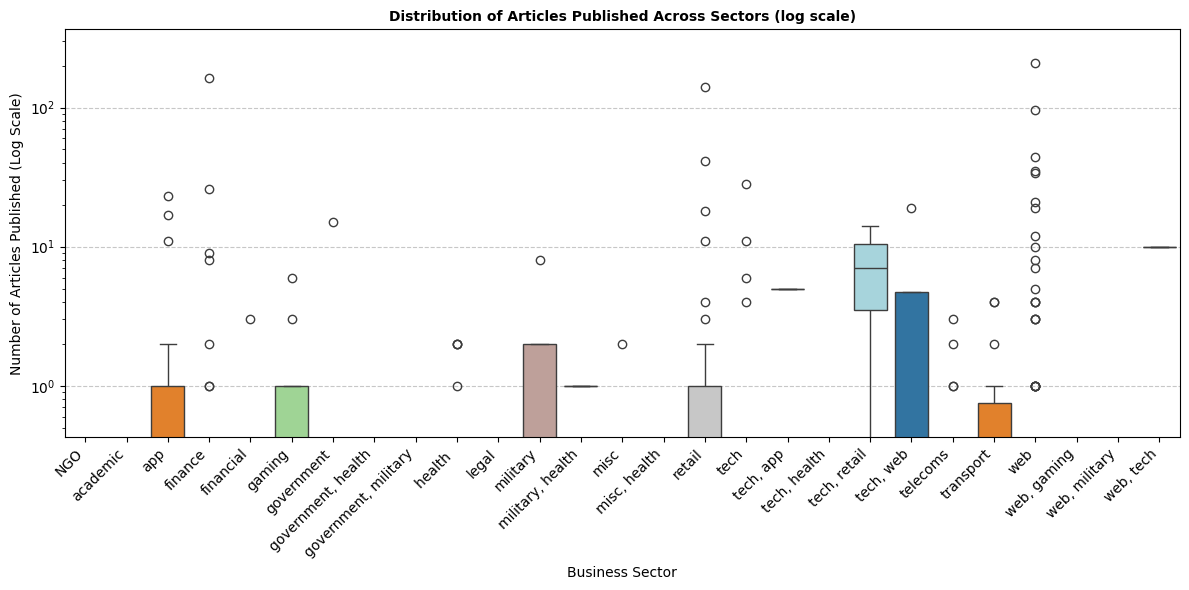

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)


# Prepare data: Group by sector and breach ID, calculate necessary aggregates
sectorSummary = (
    data.groupby(['sector', 'ID'])
    .agg({
        'Headline': 'count',  # Count unique articles per breach
        'records lost': 'first',  # Sum of records lost for the breach
        'year': 'first',  # Year of the breach
    })
    .reset_index()
)

# Rename columns for clarity
sectorSummary.rename(columns={'Headline': 'article_count'}, inplace=True)

# Add the company name for outlier labeling
sectorSummary['organisation'] = (
    data.groupby(['sector', 'ID'])['organisation']
    .first()
    .reset_index(drop=True)
)

# Sort x-axis sectors by the HIGHEST MEDIAN article count
order = sectorSummary.groupby('sector')['article_count'].median().sort_values(ascending=False).index

# Identify outliers using the IQR method for each sector
outliers = []
for sector in sectorSummary['sector'].unique():
    sector_data = sectorSummary[sectorSummary['sector'] == sector]
    Q1 = sector_data['article_count'].quantile(0.25)
    Q3 = sector_data['article_count'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    sector_outliers = sector_data[
        (sector_data['article_count'] < lower_bound) |
        (sector_data['article_count'] > upper_bound)
    ]
    outliers.append(sector_outliers)

# Plotting the box plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    x='sector',
    y='article_count',
    data=sectorSummary,
    # order=order,
    palette='tab20',
    showfliers=True
)

# Use a log scale for the y-axis
ax.set_yscale('log')



# Add titles and axis labels
plt.title('Distribution of Articles Published Across Sectors (log scale)', fontsize=10, fontweight='bold')
plt.xlabel('Business Sector', fontsize=10)
plt.ylabel('Number of Articles Published (Log Scale)', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# # Annotate outliers with the organization name
# outliers = pd.concat(outliers)
# for _, row in outliers.iterrows():
#     ax.annotate(
#         f"{row['organisation']} ({row['year']})",
#         (row['sector'], row['article_count']),
#         xytext=(0, 5),
#         textcoords='offset points',
#         fontsize=9
#     )

# Add grid lines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_1441/2698513281.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


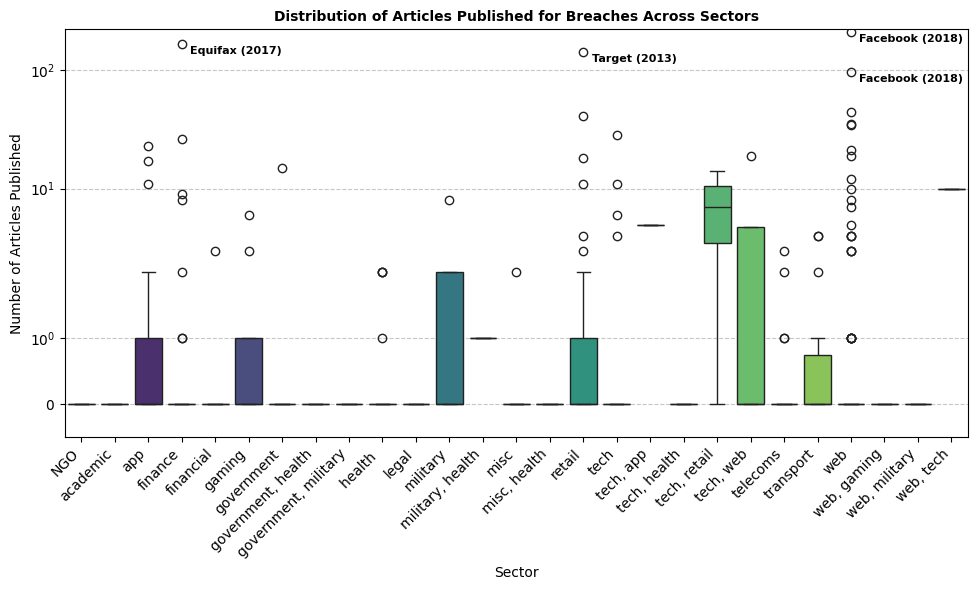

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Prepare data: Group by sector and breach ID, calculate necessary aggregates
sector_summary = (
    data.groupby(['sector', 'ID'])
    .agg({
        'Headline': 'count',  # Count unique articles per breach
        'records lost': 'first',  # Total records lost for the breach
        'year': 'first',  # Year of the breach
    })
    .reset_index()
)

# Rename columns for clarity
sector_summary.rename(columns={'Headline': 'article_count'}, inplace=True)

# Add the organization name for outlier labeling
sector_summary['organisation'] = (
    data.groupby(['sector', 'ID'])['organisation']
    .first()
    .reset_index(drop=True)
)

# Sort x-axis sectors by the highest median article count
# order = sector_summary.groupby('sector')['article_count'].median().sort_values(ascending=False).index

# Plotting the box plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='sector',
    y='article_count',
    data=sector_summary,
    # order=order,
    palette='viridis',
    showfliers=True,
)

# Annotate outliers using the IQR method
outliers = []
for sector in sector_summary['sector'].unique():
    sector_data = sector_summary[sector_summary['sector'] == sector]
    Q1 = sector_data['article_count'].quantile(0.25)
    Q3 = sector_data['article_count'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    sector_outliers = sector_data[
        (sector_data['article_count'] < lower_bound) |
        (sector_data['article_count'] > upper_bound)
    ]
    outliers.append(sector_outliers)

# Consolidate outliers and annotate selected ones
outliers = pd.concat(outliers)
for _, row in outliers.iterrows():
    if row['article_count'] > 45:  # Annotate only large outliers to avoid clutter
        ax.annotate(
            f"{row['organisation']} ({row['year']})",
            (row['sector'], row['article_count']),
            xytext=(6, -7),
            textcoords='offset points',
            fontsize=8,
            fontweight='bold'
        )

# # Annotate selected outliers with `adjustText`
# texts = []
# for _, row in outliers.iterrows():
#     if row['article_count'] > 10:  # Annotate only larger outliers
#         text = plt.text(
#             x=row['sector'],
#             y=row['article_count'],
#             s=f"{row['organisation']} ({row['year']})",
#             fontsize=8,
#             color='black',
#         )
#         texts.append(text)

# # Automatically adjust overlapping text labels
# adjust_text(
#     texts,
#     ax=ax,
#     arrowprops=dict(arrowstyle="->", lw=0.1, color="black"),
# )

ax.set_yscale('symlog')

ax.set_ylim(-0.5, None)

# Add titles and labels
plt.title(
    'Distribution of Articles Published for Breaches Across Sectors',
    fontsize=10,
    fontweight='bold'
)
plt.xlabel('Sector', fontsize=10)
plt.ylabel('Number of Articles Published', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better fit
plt.tight_layout()

# Show plot
plt.show()


In [39]:
# JUST BREACHES PRINT WITHIN SINGLE SECTOR
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv(
    "../../data/article_company_breach/joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Filter data for the given sector (e.g., 'Government')
sector_data = data[data['sector'] == 'web']

# Aggregate data to get unique article counts per breach (ID)
sector_summary = (
    sector_data.groupby(['ID'])
    .agg({
        'Headline': 'nunique',  # Count unique articles per breach
        'organisation': 'first',  # Get the organization name
        'records lost': 'first',  # Get the records lost
        'year': 'first'  # Get the year of the breach
    })
    .reset_index()
)

# Rename 'Headline' to 'article_count' for clarity
sector_summary.rename(columns={'Headline': 'article_count'}, inplace=True)

sector_summary.sort_values('article_count', ascending=False, inplace=True)

# Print the summary of breaches with article counts
for _, row in sector_summary.iterrows():
    # print(f"{row['ID']}, {row['organisation']} ({row['year']}) - {row['article_count']}")
    print(f"{row['article_count']}")

208
96
44
35
34
21
19
12
10
8
7
5
4
4
4
3
3
3
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/tmp/ipykernel_1565/1199379718.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


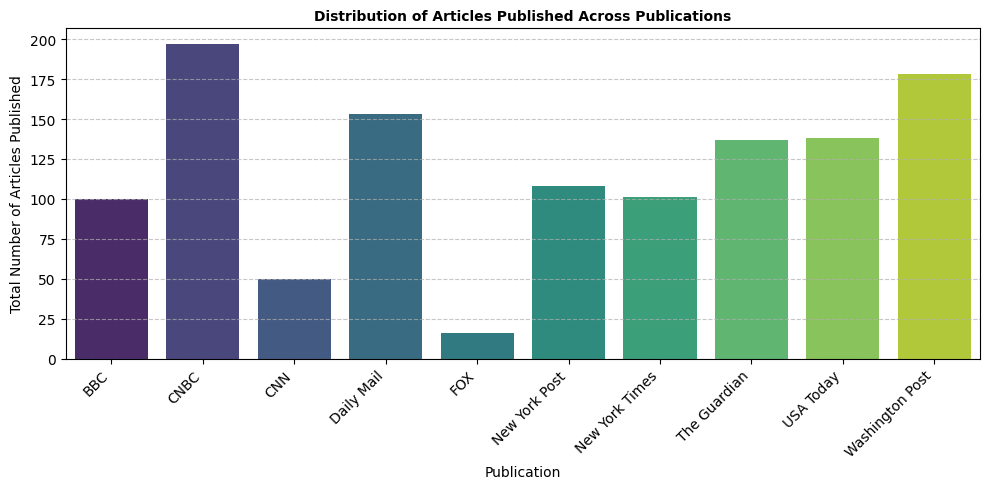

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Count the number of articles per sector (unique headlines)
sector_article_count = data.groupby('Publication')['Headline'].nunique().reset_index()

# Rename the column for clarity
sector_article_count.rename(columns={'Headline': 'article_count'}, inplace=True)

# Sort sectors by the number of articles (optional)
# sector_article_count = sector_article_count.sort_values(by='article_count', ascending=False)

# Plot: Distribution of articles per sector
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Publication', 
    y='article_count', 
    data=sector_article_count, 
    palette='viridis'
)

# Customize the plot
plt.title('Distribution of Articles Published Across Publications', fontsize=10, fontweight='bold')
plt.xlabel('Publication', fontsize=10)
plt.ylabel('Total Number of Articles Published', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_1441/4281327783.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


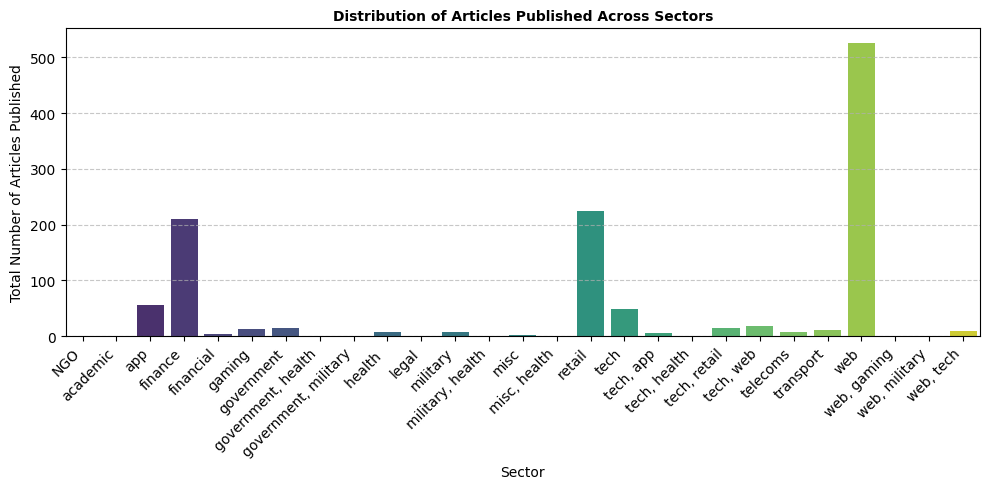

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Count the number of articles per sector (unique headlines)
sector_article_count = data.groupby('sector')['Headline'].nunique().reset_index()

# Rename the column for clarity
sector_article_count.rename(columns={'Headline': 'article_count'}, inplace=True)

# Sort sectors by the number of articles (optional)
# sector_article_count = sector_article_count.sort_values(by='article_count', ascending=False)

# Plot: Distribution of articles per sector
plt.figure(figsize=(10, 5))
sns.barplot(
    x='sector', 
    y='article_count', 
    data=sector_article_count, 
    palette='viridis',
    errorbar=('ci', 95),
    capsize=5
)

# Customize the plot
plt.title('Distribution of Articles Published Across Sectors', fontsize=10, fontweight='bold')
plt.xlabel('Sector', fontsize=10)
plt.ylabel('Total Number of Articles Published', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# # Count the number of articles per sector (unique headlines)
# breach_article_count = data.groupby('ID').agg({
#     'Headline': 'nunique',
#     'sector': 'first',
#     'organisation': 'first',
#     'year': 'first'
# }
# ).reset_index()

# # Rename the column for clarity
# breach_article_count.rename(columns={'Headline': 'article_count'}, inplace=True)

# # Sort sectors by the number of articles (optional)
# breach_article_count = breach_article_count.sort_values(by='article_count', ascending=False)

# # Retain only those with count > 1
# breach_article_count = breach_article_count[breach_article_count['article_count'] > 1]

# # Create a custom label combining organisation and year
# breach_article_count['label'] = breach_article_count['organisation'] + ' (' + breach_article_count['year'].astype(str) + ')'

# # Plot: Distribution of articles per sector
# plt.figure(figsize=(5, 12))
# sns.barplot(
#     x='article_count', 
#     y='label', 
#     data=breach_article_count, 
#     palette='viridis',
#     ci=None
# )

# # Customize the plot
# # plt.title('Distribution of Articles Across Sectors', fontsize=14, fontweight='bold')
# # plt.xlabel('Sector', fontsize=10)
# # plt.ylabel('Number of Articles Published', fontsize=10)
# plt.xticks(rotation=45, ha='right', fontsize=10)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Show the plot
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_2417/160190337.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


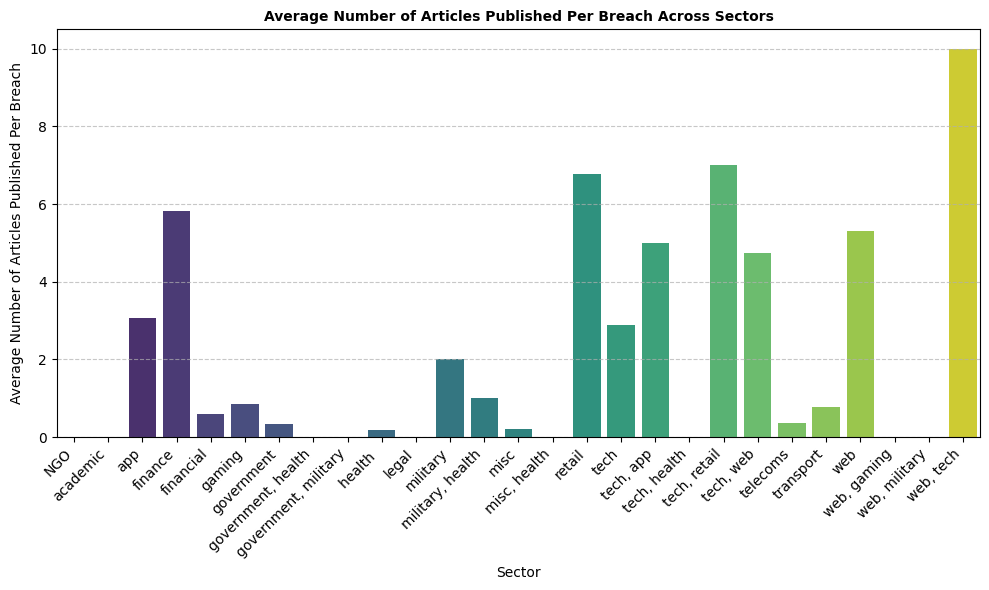

In [65]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Calculate the total number of articles and breaches per sector
sector_stats = data.groupby('sector').agg(
    total_articles=('Headline', 'nunique'),  # Count unique articles
    total_breaches=('ID', 'nunique')        # Count unique breaches
).reset_index()

# Calculate the average number of articles per breach
sector_stats['avg_articles_per_breach'] = sector_stats['total_articles'] / sector_stats['total_breaches']

# Sort sectors by the average articles per breach (optional)
# sector_stats = sector_stats.sort_values(by='avg_articles_per_breach', ascending=False)

# Plot: Average articles per breach per sector
plt.figure(figsize=(10, 6))
sns.barplot(
    x='sector', 
    y='avg_articles_per_breach', 
    data=sector_stats, 
    palette='viridis'
)

# Customize the plot
plt.title('Average Number of Articles Published Per Breach Across Sectors', fontsize=10, fontweight='bold')
plt.xlabel('Sector', fontsize=10)
plt.ylabel('Average Number of Articles Published Per Breach', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


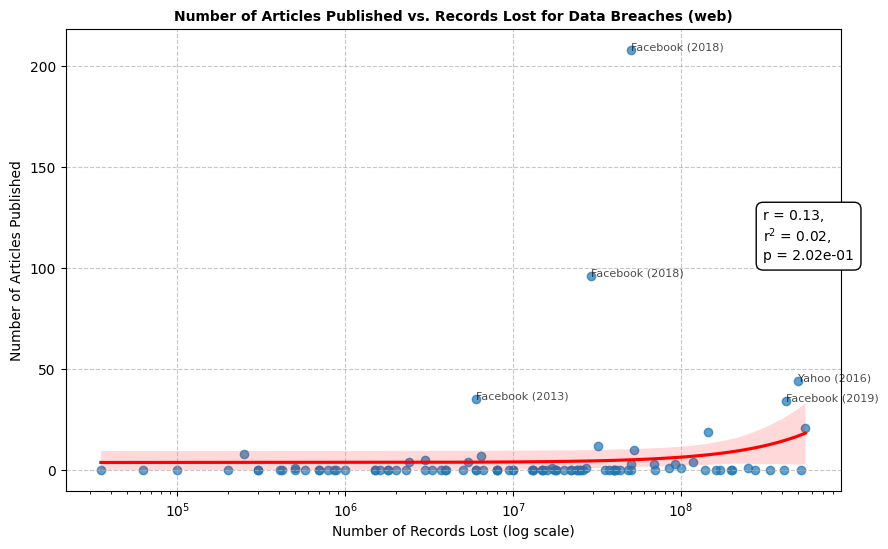

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Prepare data for plotting

# Filter data for the given sector (e.g., 'Government')
data = data[data['sector'] == 'finance']

individual_breaches = data.groupby('ID').agg({
    'organisation': 'first',       # Company name
    'year': 'first',               # Year of breach
    'records lost': 'first',       # Records lost
    'Headline': 'count',            # Count of articles (number of headlines)
    'sector': 'first'
}).reset_index()

# Rename columns for clarity
individual_breaches.rename(columns={'Headline': 'Article Count'}, inplace=True)

from scipy.stats import pearsonr, linregress

# Calculate correlation coefficient and regression parameters
correlation, _ = pearsonr(individual_breaches['records lost'], individual_breaches['Article Count'])
slope, intercept, rvalue, pvalue, stderr = linregress(
    individual_breaches['records lost'], 
    individual_breaches['Article Count']
)

# Plot scatter with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=individual_breaches, 
    x='records lost', 
    y='Article Count',
    scatter_kws={'alpha': 0.7}, 
    line_kws={'color': 'red'}
)

plt.xscale('log')

for i, row in individual_breaches.iterrows():
    if(row['Article Count'] > 30):
        plt.text(
            x=row['records lost'], 
            y=row['Article Count'], 
            s=f"{row['organisation']} ({row['year']})", 
            fontsize=8, alpha=0.7
        )

plt.title('Number of Articles Published vs. Records Lost for Data Breaches (finance)', fontsize=10, fontweight='bold')
plt.xlabel('Number of Records Lost (log scale)', fontsize=10)
plt.ylabel('Number of Articles Published', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.annotate(
    f'r = {correlation:.2f},\nr$^2$ = {rvalue**2:.2f},\np = {pvalue:.2e}', 
    xy=(0.9, 0.5), xycoords='axes fraction',
    fontsize=10, color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.show()